In [1]:
# 03_reporting.ipynb — Executive Summary (E-commerce)
import sys, os, pandas as pd, numpy as np, matplotlib.pyplot as plt
sys.path.append(os.path.abspath(".."))   # allow imports from ../src
from src.utils import clean_column_names

pd.options.display.float_format = "{:,.2f}".format

In [3]:
RAW_PATH = "../data/raw/ecommerce.csv"

df = pd.read_csv(RAW_PATH, encoding="ISO-8859-1")
df = clean_column_names(df)
df["invoicedate"] = pd.to_datetime(df["invoicedate"], errors="coerce")
df["line_total"]   = df["quantity"] * df["unitprice"]

# Split sales vs returns
sales   = df[df["quantity"] > 0].copy()
returns = df[df["quantity"] < 0].copy()

date_min, date_max = df["invoicedate"].min(), df["invoicedate"].max()

In [4]:
kpis = {
    "total_revenue": sales["line_total"].sum(),
    "aov": sales.groupby("invoiceno")["line_total"].sum().mean(),
    "unique_customers": sales["customerid"].nunique(),
    "repeat_customers": sales.groupby("customerid")["invoiceno"].nunique().gt(1).sum(),
    "return_rate_pct": abs(returns["line_total"].sum()) / max(sales["line_total"].sum(), 1) * 100,
    "date_min": date_min.date() if pd.notna(date_min) else None,
    "date_max": date_max.date() if pd.notna(date_max) else None,
}
kpis

{'total_revenue': 10644560.424,
 'aov': 513.5353350057893,
 'unique_customers': 4339,
 'repeat_customers': 2845,
 'return_rate_pct': 8.425077732453671,
 'date_min': datetime.date(2010, 12, 1),
 'date_max': datetime.date(2011, 12, 9)}

In [5]:
country_rev = (sales.groupby("country")["line_total"]
               .sum().sort_values(ascending=False))
product_rev = (sales.groupby(["stockcode","description"], dropna=False)["line_total"]
               .sum().sort_values(ascending=False))

top_countries = country_rev.head(10).copy()
top_products  = product_rev.head(10).copy()

top_countries.head(), top_products.head()

(country
 United Kingdom   9,003,097.96
 Netherlands        285,446.34
 EIRE               283,453.96
 Germany            228,867.14
 France             209,715.11
 Name: line_total, dtype: float64,
 stockcode  description                       
 DOT        DOTCOM POSTAGE                       206,248.77
 22423      REGENCY CAKESTAND 3 TIER             174,484.74
 23843      PAPER CRAFT , LITTLE BIRDIE          168,469.60
 85123A     WHITE HANGING HEART T-LIGHT HOLDER   104,340.29
 47566      PARTY BUNTING                         99,504.33
 Name: line_total, dtype: float64)

In [6]:
ref_date = sales["invoicedate"].max()

rfm = (sales.groupby("customerid")
       .agg(recency=("invoicedate", lambda x: (ref_date - x.max()).days),
            frequency=("invoiceno", "nunique"),
            monetary=("line_total", "sum"))
       .reset_index())

# Quantile scores (robust with rank to break ties)
rfm["R_score"] = pd.qcut(rfm["recency"].rank(method="first"), 5, labels=[5,4,3,2,1]).astype(int)
rfm["F_score"] = pd.qcut(rfm["frequency"].rank(method="first"), 5, labels=[1,2,3,4,5]).astype(int)
rfm["M_score"] = pd.qcut(rfm["monetary"].rank(method="first"), 5, labels=[1,2,3,4,5]).astype(int)

def segment(r,f,m):
    if r >= 4 and f >= 4 and m >= 4: return "Champions"
    if r >= 3 and f >= 3 and m >= 3: return "Loyal"
    if r >= 4 and f <= 2:            return "New Customers"
    if r <= 2 and m <= 2:            return "At Risk"
    return "Others"

rfm["Segment"] = rfm.apply(lambda row: segment(row["R_score"],row["F_score"],row["M_score"]), axis=1)

segment_summary = (rfm.groupby("Segment")
                   .agg(customers=("customerid","count"),
                        avg_recency=("recency","mean"),
                        avg_frequency=("frequency","mean"),
                        avg_monetary=("monetary","mean"),
                        total_monetary=("monetary","sum"))
                   .sort_values("total_monetary", ascending=False))
segment_summary

,customers,avg_recency,avg_frequency,avg_monetary,total_monetary
Segment,,,,,
Champions,947,11.54,11.16,"6,077.63","5,755,513.22"
Loyal,761,34.06,4.17,"1,874.81","1,426,733.72"
Others,1296,102.54,2.37,"1,029.79","1,334,607.92"
At Risk,1024,216.83,1.31,245.49,"251,384.47"
New Customers,311,17.08,1.24,460.35,"143,168.57"


In [7]:
from IPython.display import Markdown, display

display(Markdown(f"""
## Executive Summary

**Date range:** {kpis['date_min']} → {kpis['date_max']}  
**Total Revenue:** £{kpis['total_revenue']:,.0f}  
**Average Order Value (AOV):** £{kpis['aov']:,.2f}  
**Unique Customers:** {kpis['unique_customers']:,}  
**Repeat Customers:** {kpis['repeat_customers']:,}  
**Return Rate:** {kpis['return_rate_pct']:.2f}%
"""))


## Executive Summary

**Date range:** 2010-12-01 → 2011-12-09  
**Total Revenue:** £10,644,560  
**Average Order Value (AOV):** £513.54  
**Unique Customers:** 4,339  
**Repeat Customers:** 2,845  
**Return Rate:** 8.43%


In [8]:
top_countries_tbl = (top_countries.reset_index()
                     .rename(columns={"country":"Country", "line_total":"Revenue"})
                     .assign(Revenue=lambda d: d["Revenue"].map(lambda v: f"£{v:,.0f}")))
top_products_tbl  = (top_products.reset_index()
                     .rename(columns={"stockcode":"StockCode", "description":"Description", "line_total":"Revenue"})
                     .assign(Revenue=lambda d: d["Revenue"].map(lambda v: f"£{v:,.0f}")))

display(Markdown("### Top 10 Countries by Revenue"))
display(top_countries_tbl)

display(Markdown("### Top 10 Products by Revenue"))
display(top_products_tbl)

### Top 10 Countries by Revenue

,Country,Revenue
0,United Kingdom,"£9,003,098"
1,Netherlands,"£285,446"
2,EIRE,"£283,454"
3,Germany,"£228,867"
4,France,"£209,715"
5,Australia,"£138,521"
6,Spain,"£61,577"
7,Switzerland,"£57,090"
8,Belgium,"£41,196"
9,Sweden,"£38,378"


### Top 10 Products by Revenue

,StockCode,Description,Revenue
0,DOT,DOTCOM POSTAGE,"£206,249"
1,22423,REGENCY CAKESTAND 3 TIER,"£174,485"
2,23843,"PAPER CRAFT , LITTLE BIRDIE","£168,470"
3,85123A,WHITE HANGING HEART T-LIGHT HOLDER,"£104,340"
4,47566,PARTY BUNTING,"£99,504"
5,85099B,JUMBO BAG RED RETROSPOT,"£94,340"
6,23166,MEDIUM CERAMIC TOP STORAGE JAR,"£81,701"
7,M,Manual,"£78,110"
8,POST,POSTAGE,"£78,102"
9,23084,RABBIT NIGHT LIGHT,"£66,965"


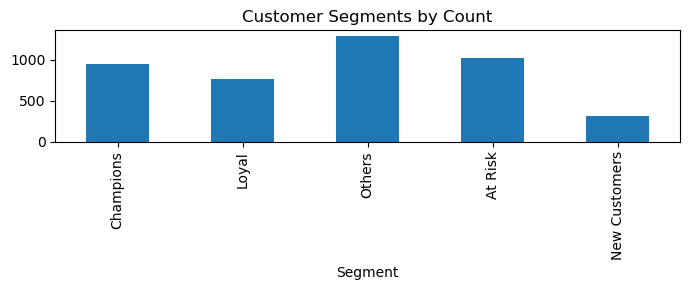

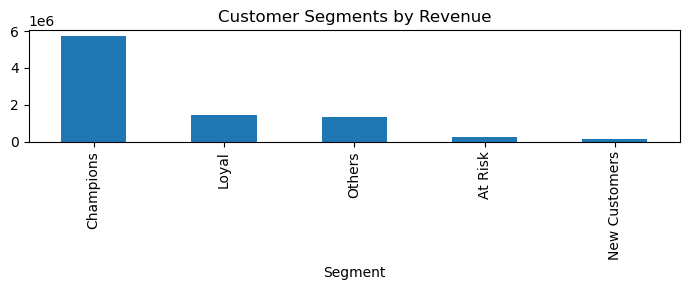

### RFM Segment Summary

,customers,avg_recency,avg_frequency,avg_monetary,total_monetary
Segment,,,,,
Champions,947,11.50,11.16,"6,078.00","5,755,513.00"
Loyal,761,34.10,4.17,"1,875.00","1,426,734.00"
Others,1296,102.50,2.37,"1,030.00","1,334,608.00"
At Risk,1024,216.80,1.31,245.00,"251,384.00"
New Customers,311,17.10,1.24,460.00,"143,169.00"


In [9]:
# ensure plots directory local to this notebook
PLOT_DIR = "plots"; os.makedirs(PLOT_DIR, exist_ok=True)

ax = segment_summary["customers"].plot(kind="bar", figsize=(7,3), title="Customer Segments by Count")
plt.tight_layout(); plt.savefig(f"{PLOT_DIR}/customer_segments_by_count.png"); plt.show()

ax = segment_summary["total_monetary"].plot(kind="bar", figsize=(7,3), title="Customer Segments by Revenue")
plt.tight_layout(); plt.savefig(f"{PLOT_DIR}/customer_segments_by_revenue.png"); plt.show()

display(Markdown("### RFM Segment Summary"))
display(segment_summary.assign(
    avg_recency=lambda d: d["avg_recency"].round(1),
    avg_frequency=lambda d: d["avg_frequency"].round(2),
    avg_monetary=lambda d: d["avg_monetary"].round(0),
    total_monetary=lambda d: d["total_monetary"].round(0)
))

In [10]:
display(Markdown(f"""
## Key Findings
- Revenue is concentrated: top countries and a small set of products drive a large share of sales.
- Returns account for **{kpis['return_rate_pct']:.2f}%** of sales value — material enough to impact profit.
- **RFM** shows a small **Champions** group delivering outsized revenue; a sizable **At Risk** group.

## Recommendations
1. **Champion loyalty**: targeted perks/early access to lift repeat purchases and AOV.
2. **Win-back At Risk**: timed emails with tailored offers; measure lift vs control.
3. **Returns reduction**: investigate top-returning SKUs/countries; improve descriptions/packaging.
4. **Assortment focus**: double down on top products; test bundles in high-revenue countries.

## Next Steps
- Ship a lightweight KPI dashboard (Tableau/Power BI/Dash).
- Run A/B tests on win-back and loyalty offers.
- Extend to CLV modeling and cohort retention analysis.
"""))


## Key Findings
- Revenue is concentrated: top countries and a small set of products drive a large share of sales.
- Returns account for **8.43%** of sales value — material enough to impact profit.
- **RFM** shows a small **Champions** group delivering outsized revenue; a sizable **At Risk** group.

## Recommendations
1. **Champion loyalty**: targeted perks/early access to lift repeat purchases and AOV.
2. **Win-back At Risk**: timed emails with tailored offers; measure lift vs control.
3. **Returns reduction**: investigate top-returning SKUs/countries; improve descriptions/packaging.
4. **Assortment focus**: double down on top products; test bundles in high-revenue countries.

## Next Steps
- Ship a lightweight KPI dashboard (Tableau/Power BI/Dash).
- Run A/B tests on win-back and loyalty offers.
- Extend to CLV modeling and cohort retention analysis.


In [11]:
# from inside Jupyter (uses shell)
!jupyter nbconvert 03_reporting.ipynb --to html --output 03_reporting_report.html
# For slides instead of HTML report:
# !jupyter nbconvert 03_reporting.ipynb --to slides --output 03_reporting_slides.html

[NbConvertApp] Converting notebook 03_reporting.ipynb to html
[NbConvertApp] Writing 590096 bytes to 03_reporting_report.html


In [14]:
# Rebuild key values if needed (expects sales/returns already defined in this notebook)
import os, pandas as pd, numpy as np, sys
from pathlib import Path

# Make sure we can import utils if we ever need it
sys.path.append(os.path.abspath(".."))

# --- If KPIs don't exist, recompute quickly from raw ---
need_recompute = False
for v in ["kpis", "top_countries", "segment_summary"]:
    if v not in globals():
        need_recompute = True
        break

if need_recompute:
    from src.utils import clean_column_names
    RAW_PATH = "../data/raw/ecommerce.csv"
    df = pd.read_csv(RAW_PATH, encoding="ISO-8859-1")
    df = clean_column_names(df)
    df["invoice_date"] = pd.to_datetime(df["invoice_date"], errors="coerce")
    df["line_total"] = df["quantity"] * df["unit_price"]
    sales = df[df["quantity"] > 0].copy()
    returns = df[df["quantity"] < 0].copy()

    date_min, date_max = df["invoice_date"].min(), df["invoice_date"].max()
    kpis = {
        "total_revenue": sales["line_total"].sum(),
        "aov": sales.groupby("invoice_no")["line_total"].sum().mean(),
        "unique_customers": sales["customer_id"].nunique(),
        "repeat_customers": sales.groupby("customer_id")["invoice_no"].nunique().gt(1).sum(),
        "return_rate_pct": abs(returns["line_total"].sum()) / max(sales["line_total"].sum(), 1) * 100,
        "date_min": date_min.date() if pd.notna(date_min) else None,
        "date_max": date_max.date() if pd.notna(date_max) else None,
    }

    top_countries = (sales.groupby("country")["line_total"]
                     .sum().sort_values(ascending=False).head(3))

    ref_date = sales["invoice_date"].max()
    rfm = (sales.groupby("customer_id")
           .agg(recency=("invoice_date", lambda x: (ref_date - x.max()).days),
                frequency=("invoice_no","nunique"),
                monetary=("line_total","sum"))
           .reset_index())
    rfm["R_score"] = pd.qcut(rfm["recency"].rank(method="first"), 5, labels=[5,4,3,2,1]).astype(int)
    rfm["F_score"] = pd.qcut(rfm["frequency"].rank(method="first"), 5, labels=[1,2,3,4,5]).astype(int)
    rfm["M_score"] = pd.qcut(rfm["monetary"].rank(method="first"), 5, labels=[1,2,3,4,5]).astype(int)
    def segment(r,f,m):
        if r >= 4 and f >= 4 and m >= 4: return "Champions"
        if r >= 3 and f >= 3 and m >= 3: return "Loyal"
        if r >= 4 and f <= 2:            return "New Customers"
        if r <= 2 and m <= 2:            return "At Risk"
        return "Others"
    rfm["Segment"] = rfm.apply(lambda row: segment(row["R_score"],row["F_score"],row["M_score"]), axis=1)
    segment_summary = (rfm.groupby("Segment")
                       .agg(customers=("customer_id","count"),
                            total_monetary=("monetary","sum"))
                       .sort_values("total_monetary", ascending=False))

# --- Build the markdown ---
def money(v): return f"£{v:,.0f}"
date_range = f"{kpis['date_min']} → {kpis['date_max']}"
rows = "\n".join([f"| {idx} | {money(val)} |" for idx, val in top_countries.items()])

total_customers = int(segment_summary["customers"].sum())
total_revenue   = float(segment_summary["total_monetary"].sum())
seg_lines = []
for seg, row in segment_summary.iterrows():
    cust_pct = row["customers"]/total_customers if total_customers else 0
    rev_pct  = row["total_monetary"]/total_revenue if total_revenue else 0
    seg_lines.append(f"- **{seg}** → {cust_pct:.1%} of customers driving {rev_pct:.1%} of revenue")
segments_block = "\n".join(seg_lines)

readme_md = f"""# 🛍️ E-commerce Customer & Revenue Analysis

## 📌 Overview
This project is part of my **Codecademy Data Analytics Portfolio**.  
It analyzes ~500k transactions from an e-commerce dataset (2010–2011) to uncover **revenue drivers, customer segments, and returns**.  

---

## 🔑 Key Findings
- **Date Range:** {date_range}
- **Total Revenue:** {money(kpis['total_revenue'])}
- **Average Order Value (AOV):** {money(kpis['aov'])}
- **Unique Customers:** {kpis['unique_customers']:,}
- **Repeat Customers:** {kpis['repeat_customers']:,}
- **Return Rate:** {kpis['return_rate_pct']:.2f}%

---

## 🌍 Top Countries
| Country | Revenue |
|--------|---------|
{rows}

---

## 🧩 Customer Segmentation (RFM)
{segments_block}

📊 See plots in `/notebooks/plots/` for visuals.

---

## 📂 Repository Structure

"""

# --- Pick the correct repo root whether you're in /notebooks or root ---
repo_root = Path.cwd()
if repo_root.name == "notebooks":
    repo_root = repo_root.parent

out_path = repo_root / "README.md"
out_path.write_text(readme_md, encoding="utf-8")
print("WROTE:", out_path)

# Show the first few lines so you can confirm values
print("--- PREVIEW ---")
print(readme_md.splitlines()[0:20])

WROTE: /home/rochellea6464/Data-Analytics-Final-Portfolio-Project/README.md
--- PREVIEW ---
['# 🛍️ E-commerce Customer & Revenue Analysis', '', '## 📌 Overview', 'This project is part of my **Codecademy Data Analytics Portfolio**.  ', 'It analyzes ~500k transactions from an e-commerce dataset (2010–2011) to uncover **revenue drivers, customer segments, and returns**.  ', '', '---', '', '## 🔑 Key Findings', '- **Date Range:** 2010-12-01 → 2011-12-09', '- **Total Revenue:** £10,644,560', '- **Average Order Value (AOV):** £514', '- **Unique Customers:** 4,339', '- **Repeat Customers:** 2,845', '- **Return Rate:** 8.43%', '', '---', '', '## 🌍 Top Countries', '| Country | Revenue |']
